# README
- Notebook版
- このNotebookだけで成立するようにしています
    - KaggleNotebook や Colaboratory で実行がしやすくなる
    - 継続的な改善はしにくいので使い捨てと割り切ったほうがいい

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# DataPath
- パスの管理を任せる
- KaggleやColaboratoryで実行する場合は修正が必要

In [2]:
from enum import Enum
from pathlib import Path


class DataPath(Enum):
    Root = Path('../')
#     Input = Root / 'input'
    Input = Root / 'input/digit-recognizer'  # KaggleNotebookに対応
    Submission = Root / 'submissions'

    TrainCsv = Input / 'train.csv'
    TestCsv = Input / 'test.csv'

    SubmissionCsv = Input / 'sample_submission.csv'

In [3]:
# ファイルの存在を確認する
assert DataPath.TrainCsv.value.exists()
assert DataPath.TestCsv.value.exists()

# Dataset

In [4]:
import numpy as np
from torch.utils.data import Dataset


class TrainDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx].reshape(1, 28, 28).astype(np.float32)

        label = self.y[idx]

        return image, label


class TestDataset(Dataset):
    def __init__(self, X: np.ndarray):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].reshape(1, 28, 28).astype(np.float32)


In [5]:
def prepare_data_loaders(batch_size):
    train = pd.read_csv(DataPath.TrainCsv.value)

    X = train.iloc[:, 1:].values
    y = train.iloc[:, 0].values
    X_train, X_valid, y_train, y_valid = train_test_split(X,

                                                          y,
                                                          train_size=0.8,
                                                          random_state=0)
    train_dataset = TrainDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid_dataset = TrainDataset(X_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader


In [6]:
torch.manual_seed(0)

BATCH_SIZE = 700

# 1. DatasetとDataLoader
train_loader, valid_loader = prepare_data_loaders(BATCH_SIZE)

# Device

In [7]:
# GPUが利用できるなら使う
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'Use {device}')

Use cuda:0


# Model

In [8]:
import torch
from torch import nn


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 3, kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(3, 6, kernel_size=(2, 2))

        self.fc1 = nn.Linear(6 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 10)

        self.relu = nn.ReLU(inplace=True)
        self.max_pool2d = nn.MaxPool2d(kernel_size=(2, 2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = x.view(-1, 6 * 6 * 6)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)

        return x


In [9]:
# 2. モデル(ネットワーク)
model: nn.Module = SimpleCNN()
model.to(device)  # GPUに転送

# 最適化アルゴリズムと損失関数
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# 学習


In [10]:
def run_train_epoch(model, train_loader, criterion, optimizer, epoch):
    model.train()

    running_loss = 0.0
    accuracy = 0.0

    for images, labels in train_loader:
        # GPUに転送
        
        images, labels = images.to(device), labels.to(device)
        # 勾配初期化
        optimizer.zero_grad()

        # 順伝播計算
        outputs = model(images)
        # 損失の計算
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()

        # 重みの更新
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch} Train Loss: {epoch_loss:.4f}')
    
    return epoch_loss

def much_train_epoch(model, train_loader, criterion, optimizer, epoch):
    model.eval()
    
    accuracy = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, labels_pred = torch.max(outputs,dim=1)
        currect_num = (labels_pred == labels).sum().item()
        
        accuracy += currect_num 
    
    accuracy_rate = accuracy / len(train_loader.dataset)
    print(f'Epoch: {epoch} Train Accuracy:{accuracy_rate:.4f}')
    
    return accuracy_rate
    
def run_valid_epoch(model, valid_loader, criterion, epoch):
    model.eval()

    running_loss = 0.0
    accuracy = 0.0 
    

    with torch.no_grad():
        for images, labels in valid_loader:
            # GPUに転送
            images, labels = images.to(device), labels.to(device)
        
            outputs = model(images)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            
            _, labels_pred = torch.max(outputs,dim=1)
            currect_num = (labels_pred == labels).sum().item()
            
            accuracy += currect_num 

    epoch_loss = running_loss / len(valid_loader.dataset)
    accuracy_rate = accuracy / len(valid_loader.dataset)
    
    print(f'Epoch: {epoch} Valid Loss: {epoch_loss:.4f}')
    print(f'Epoch: {epoch} Valid Accuracy:{accuracy_rate:.4f}')
    
    return epoch_loss,accuracy_rate

In [11]:
# 3. 学習
NUM_EPOCHS = 10
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss = run_train_epoch(model, train_loader, criterion, optimizer, epoch)
    acc = much_train_epoch(model, train_loader, criterion, optimizer, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    loss,acc = run_valid_epoch(model, valid_loader, criterion, epoch)
    valid_loss.append(loss)
    valid_acc.append(acc)
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.8215


 10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Epoch: 1 Train Accuracy:0.9216
Epoch: 1 Valid Loss: 0.2587
Epoch: 1 Valid Accuracy:0.9223
Epoch: 2 Train Loss: 0.2007


 20%|██        | 2/10 [00:03<00:12,  1.56s/it]

Epoch: 2 Train Accuracy:0.9530
Epoch: 2 Valid Loss: 0.1633
Epoch: 2 Valid Accuracy:0.9527
Epoch: 3 Train Loss: 0.1388


 30%|███       | 3/10 [00:04<00:10,  1.51s/it]

Epoch: 3 Train Accuracy:0.9633
Epoch: 3 Valid Loss: 0.1312
Epoch: 3 Valid Accuracy:0.9606
Epoch: 4 Train Loss: 0.1105


 40%|████      | 4/10 [00:05<00:08,  1.46s/it]

Epoch: 4 Train Accuracy:0.9705
Epoch: 4 Valid Loss: 0.1172
Epoch: 4 Valid Accuracy:0.9646
Epoch: 5 Train Loss: 0.0950


 50%|█████     | 5/10 [00:07<00:07,  1.45s/it]

Epoch: 5 Train Accuracy:0.9732
Epoch: 5 Valid Loss: 0.1076
Epoch: 5 Valid Accuracy:0.9679
Epoch: 6 Train Loss: 0.0885


 60%|██████    | 6/10 [00:08<00:05,  1.42s/it]

Epoch: 6 Train Accuracy:0.9770
Epoch: 6 Valid Loss: 0.1023
Epoch: 6 Valid Accuracy:0.9687
Epoch: 7 Train Loss: 0.0755


 70%|███████   | 7/10 [00:09<00:04,  1.40s/it]

Epoch: 7 Train Accuracy:0.9799
Epoch: 7 Valid Loss: 0.0959
Epoch: 7 Valid Accuracy:0.9713
Epoch: 8 Train Loss: 0.0697


 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]

Epoch: 8 Train Accuracy:0.9808
Epoch: 8 Valid Loss: 0.0957
Epoch: 8 Valid Accuracy:0.9717
Epoch: 9 Train Loss: 0.0595


 90%|█████████ | 9/10 [00:12<00:01,  1.39s/it]

Epoch: 9 Train Accuracy:0.9840
Epoch: 9 Valid Loss: 0.0909
Epoch: 9 Valid Accuracy:0.9732
Epoch: 10 Train Loss: 0.0537


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]

Epoch: 10 Train Accuracy:0.9835
Epoch: 10 Valid Loss: 0.0944
Epoch: 10 Valid Accuracy:0.9719


In [12]:
from typing import List

from matplotlib import pyplot as plt


def plot_accuracy(accuracy_list: List[float]) -> None:
    plt.plot(range(1, len(accuracy_list) + 1), accuracy_list)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    


def plot_loss(loss_list: List[float]) -> None:
    plt.plot(range(1, len(loss_list) + 1), loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

## accuracy

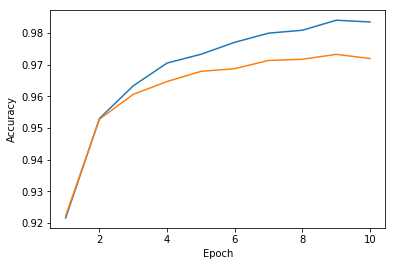

In [13]:
plot_accuracy(train_acc)
plot_accuracy(valid_acc)

## valid

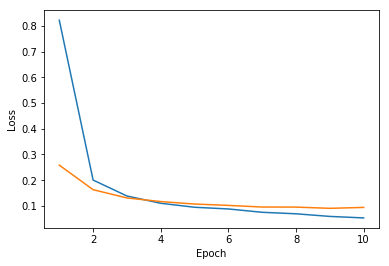

In [14]:
plot_loss(train_loss)
plot_loss(valid_loss)

# テストデータでの予測とSubmission

In [15]:
def make_predictions(model, test_loader):
    model.eval()
    predictions = np.array([], dtype=np.int)

    with torch.no_grad():
        for images in test_loader:
            # GPUに転送
            images = images.to(device)

            outputs = model(images)

            _, y_pred = torch.max(outputs, dim=1)
            y_pred_label = y_pred.cpu().numpy()

            predictions = np.append(predictions, y_pred_label)

    return predictions

In [16]:
# 4. TestDataでの予測
df_test = pd.read_csv(DataPath.TestCsv.value)
X_test = df_test.values

test_dataset = TestDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

predictions = make_predictions(model, test_loader)

In [17]:
import datetime


def make_submission_file(model, predictions):
    submit_data = pd.read_csv(DataPath.SubmissionCsv.value)
    submit_data['Label'] = predictions

    yymmddhhmmss = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    model_name = model.__class__.__name__

    # ex: '20201231_174530_SimpleNet.csv
    save_submission_path = f'{yymmddhhmmss}_{model_name}.csv'

    submit_data.to_csv(save_submission_path, index=False)
    print(f'Saved {save_submission_path}')


In [18]:
# submissionの作成
make_submission_file(model, predictions)

Saved 20191016_022807_SimpleCNN.csv


おわり